In [1]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import cv2
import glob
import time
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from skimage.feature import hog
# NOTE: the next import is only valid for scikit-learn version <= 0.17
# for scikit-learn >= 0.18 use:
# from sklearn.model_selection import train_test_split
from sklearn.cross_validation import train_test_split
import pickle
from moviepy.editor import VideoFileClip
from IPython.display import HTML

#################################Functions for feature extraction########################################
import numpy as np
import cv2
from skimage.feature import hog

def convert_color(img, conv='RGB2YCrCb'):
    if conv == 'RGB2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    if conv == 'BGR2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)
    if conv == 'RGB2LUV':
        return cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
    if conv == 'RGB2HSV':
        return cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    if conv == 'RGB2HSV':
        return cv2.cvtColor(img, cv2.COLOR_RGB2HSV)

def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, 
                                  pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), 
                                  transform_sqrt=False, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, 
                       pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), 
                       transform_sqrt=False, 
                       visualise=vis, feature_vector=feature_vec)
        return features
    

def bin_spatial(img, size=(32, 32)):
    color1 = cv2.resize(img[:,:,0], size).ravel()
    color2 = cv2.resize(img[:,:,1], size).ravel()
    color3 = cv2.resize(img[:,:,2], size).ravel()
    return np.hstack((color1, color2, color3))
                        
def color_hist(img, nbins=32):    #bins_range=(0, 256)
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features

def single_img_features(img = None, color_space='RGB', spatial_size=(32, 32), \
                        hist_bins=32, orient=9,pix_per_cell=8, cell_per_block=2, hog_channel=0, \
                        spatial_feat=True, hist_feat=True, hog_feat=True, \
                        y_start_stop = [None,None],x_start_stop = [None,None],scale = 1.0):    
    #1) Define an empty list to receive features
    img_features = []
   
    #Identify area to find the HOG features.
    w,h = img.shape[1],img.shape[0]
    if y_start_stop[0] is None:
        y_start_stop[0] = 0
    if y_start_stop[1] is None:
        y_start_stop[1] = h
    if x_start_stop[0] is None:
        x_start_stop[1] = 0
    if x_start_stop[0] is None:
        x_start_stop[1] = w

        
    #2) Apply color conversion if other than 'RGB'
    if color_space != 'RGB':
        if color_space == 'HSV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    else: feature_image = np.copy(img)      
    
    #print("feature_image: ",feature_image)
    #3) Compute spatial features if flag is set
    if spatial_feat == True:
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        #4) Append features to list
        img_features.append(spatial_features)
    #5) Compute histogram features if flag is set
    if hist_feat == True:
        hist_features = color_hist(feature_image, nbins=hist_bins)
        #6) Append features to list
        img_features.append(hist_features)
    #7) Compute HOG features if flag is set
    if hog_feat == True:
        # Call get_hog_features() with vis=False, feature_vec=True
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))
            hog_features = np.ravel(hog_features)        
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
            
        #8) Append features to list
        img_features.append(hog_features)

    #9) Return concatenated array of features
    return np.concatenate(img_features)

/root/miniconda3/envs/carnd-term1/lib/python3.5/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
########################Functions for training##########################################
veh_dir = ['./vehicles/GTI_Far','./vehicles/GTI_Left','./vehicles/GTI_MiddleClose','./vehicles/GTI_Right',
           './vehicles/KITTI_extracted']
non_veh_dir = ['./non-vehicles/GTI','./non-vehicles/Extras']

img_ext = '.png'

cars_dir = []
notcars_dir = []

for image_dir in veh_dir:
    veh_images = glob.glob(image_dir+'/*'+img_ext)
    for img in veh_images:
        cars_dir.append(img)

for image_dir in non_veh_dir:
    non_veh_images = glob.glob(image_dir+'/*'+img_ext)
    for img in non_veh_images:
        notcars_dir.append(img)

print("Number of car images:  ",len(cars_dir)," Number of notcar images: ",len(notcars_dir))
        
colorspace = 'YUV' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 9
pix_per_cell = 8
cell_per_block = 2
hog_channel = "ALL" # Can be 0, 1, 2, or "ALL"
scale = 1.0
histbins = 32
spatialsize = (32,32)

car_features = []
notcar_features = []
for car in cars_dir:
    image = mpimg.imread(car)
    car_feature = single_img_features(img = image, color_space=colorspace, spatial_size=spatialsize, \
                        hist_bins=histbins, orient=orient, pix_per_cell=pix_per_cell, \
                        cell_per_block=cell_per_block, hog_channel=hog_channel, \
                        spatial_feat=True, hist_feat=True, hog_feat=True, \
                        y_start_stop = [None,None], x_start_stop = [None,None], scale=scale)

    car_features.append(car_feature)

for notcar in notcars_dir:
    image = mpimg.imread(notcar)
    notcar_feature = single_img_features(img = image, color_space=colorspace, spatial_size=spatialsize, \
                        hist_bins=histbins, orient=orient, pix_per_cell=pix_per_cell, \
                        cell_per_block=cell_per_block, hog_channel=hog_channel, \
                        spatial_feat=True, hist_feat=True, hog_feat=True, \
                        y_start_stop = [None,None], x_start_stop = [None,None], scale=scale)

    notcar_features.append(notcar_feature)

print("Number of car features: ",len(car_features)," Number of features in each car: ",np.array(car_features[0]).shape)    
print("Number of notcar features: ",len(notcar_features)," Number of features in each notcar: ",np.array(notcar_features[0]).shape)    
#Scale images between 0 mean    
X = np.vstack((car_features, notcar_features)).astype(np.float64)                        
# Fit a per-column scaler
X_scaler = StandardScaler().fit(X)
# Apply the scaler to X
scaled_X = X_scaler.transform(X)

# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))
    
# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(
    scaled_X, y, test_size=0.2, random_state=rand_state)

print('Using:',orient,'orientations',pix_per_cell,
    'pixels per cell and', cell_per_block,'cells per block')
print('Feature vector length:', len(X_train[0]))
# Use a linear SVC 
svc = LinearSVC()
# Check the training time for the SVC
t=time.time()
svc.fit(X_train, y_train)
t2 = time.time()

print(round(t2-t, 2), 'Seconds to train SVC...')
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
# Check the prediction time for a single sample
t=time.time()


print("-------Storing Parameters done--------------")

save_path = "./svm_training.p"

svm_train = {  'colorspace': colorspace,
               'orient': orient,
               'pix_per_cell': pix_per_cell,
               'cell_per_block': cell_per_block,
               'hog_channel': hog_channel,
               'scale': scale,
               'histbins' : histbins,
               'spatialsize' : spatialsize,
               'svc' : svc,
               'scaler' : X_scaler
              }

with open(save_path, 'wb') as f:
    pickle.dump(svm_train, file=f)
    
print("Completed file pickle..")    


Number of car images:   8792  Number of notcar images:  8968
Number of car features:  8792  Number of features in each car:  (8460,)
Number of notcar features:  8968  Number of features in each notcar:  (8460,)
Using: 9 orientations 8 pixels per cell and 2 cells per block
Feature vector length: 8460
6.77 Seconds to train SVC...
Test Accuracy of SVC =  0.9924
-------Storing Parameters done--------------
Completed file pickle..


In [2]:
# Define a class to store data from video
class CarsDetected():
    def __init__(self,no_frames = 10):
        # history of rectangles previous n frames
        self.prev_frames = []
        self.no_frames = no_frames
        
    def add_frames(self, frames):
        self.prev_frames.append(frames)
        if len(self.prev_frames) > self.no_frames:
            # throw out oldest rectangle set(s)
            self.prev_frames = self.prev_frames[len(self.prev_frames)-self.no_frames:]

print('CarDetected complete..')

CarDetected complete..


In [13]:
# Define a single function that can extract features using hog sub-sampling and make predictions
def find_cars(img, xstart,xstop, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins,color_space):
    
    draw_img = np.copy(img)
    img = img.astype(np.float32)/255
    boxes = []
    
    img_tosearch = img[ystart:ystop,:,:]
    #ctrans_tosearch = img_tosearch#convert_color(img_tosearch, conv='RGB2YCrCb')
    #ctrans_tosearch = convert_color(img_tosearch, conv='RGB2YCrCb')
    if color_space != 'RGB':
        if color_space == 'HSV':
            ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2YCrCb)
    else: ctrans_tosearch = img_tosearch     
        
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
        
    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell) - cell_per_block + 1
    nyblocks = (ch1.shape[0] // pix_per_cell) - cell_per_block + 1 
    nfeat_per_block = orient*cell_per_block**2
    #print(ch1.shape)
    #print(pix_per_cell)
    #print(cell_per_block)
    #print(nxblocks,nyblocks,nfeat_per_block)
    
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell) - cell_per_block + 1
    cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step
    #print("============")
    #print(nblocks_per_window)
    #print(nxsteps,nysteps)
    
    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
    
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            # Extract HOG for this patch
            #print(ypos,ypos+nblocks_per_window,"==", xpos,xpos+nblocks_per_window)
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))

            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell

            # Extract the image patch
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))
          
            # Get color features
            spatial_features = bin_spatial(subimg, size=spatial_size)
            hist_features = color_hist(subimg, nbins=hist_bins)

            # Scale features and make a prediction
            test_features = X_scaler.transform(np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1))
            test_prediction = svc.predict(test_features)
            
            if test_prediction == 1:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                cv2.rectangle(draw_img,(xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart),(0,0,255),6) 
                boxes.append([(xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart)])
    return draw_img,boxes

def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1
        #print("Box: ", box, "heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]]: ", heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]])

    # Return updated heatmap
    return heatmap# Iterate through list of bboxes
    
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

def draw_labeled_bboxes(img, labels,xstart):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox)+xstart, np.min(nonzeroy)), (np.max(nonzerox)+xstart, np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return img

def process_img(img,process_type='VIDEO'):
    
    box_list = []
    xstart = 0
    xstop  = img.shape[1]
    ystart,ystop = None,None
    scale = None
    
    heat = np.zeros_like(img[:,:,0]).astype(np.float)

    y_start_end =[(380,480), \
                 (400,480), \
                 (380,580), \
                 (400,580), \
                 (380,680), \
                 (400,680), \
                 (380,680), \
                 (400,680)]
    scale_list = [1.0,1.0,1.5,2.0,2.5,3.5]
    
    for i in range(len(scale_list)):
        ystart = y_start_end[i][0]
        ystop =  y_start_end[i][1]
        scale = scale_list[i]
        out_img,box_list_comp = find_cars(img, xstart,xstop, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatialsize, histbins,colorspace)    
        if len(box_list_comp) > 0:
            box_list.append(box_list_comp)

    if len(box_list) > 0:
        box_list = np.concatenate(box_list)
    #print("Number of boxes after concatenation: ",np.array(box_list).shape)#, "box_list: ",box_list)


    
    if  process_type == 'IMAGE':
        # Add heat to each box in box list
        heat = add_heat(heat,box_list)
        #print("Head: ",heat[heat > 0])    
        # Apply threshold to help remove false positives
        # Heat threshold applied to 2
        heat = apply_threshold(heat,2)
        #print("heat after threshold: ",heat[heat> 0])
        # Visualize the heatmap when displaying    
        heatmap = np.clip(heat, 0, 255)

        # Find final boxes from heatmap using label function
        labels = label(heatmap)
        #print(labels[1], 'cars found')
        #plt.imshow(labels[0], cmap='gray')
        draw_img = draw_labeled_bboxes(np.copy(img), labels,xstart)
        
        for i in box_list:
            cv2.rectangle(out_img,(i[0][0], i[0][1]),(i[1][0], i[1][1]),(0,0,255),6) 
        
        
        return draw_img,out_img,heatmap,labels[0]
        
    if process_type == 'VIDEO' :    
           # add detections to the history
        if len(box_list) > 0:
            det.add_frames(box_list)
        
        for frame in det.prev_frames:
            heat = add_heat(heat, frame)
            heat = apply_threshold(heat, 1 + len(det.prev_frames)//2) #Minimum threshold will be 1
     
        labels   = label(heat)
        draw_img = draw_labeled_bboxes(np.copy(img), labels,xstart)

        
        return draw_img

print("find car complete...")

find car complete...


colorspace:  YUV
orient:  9
pix_per_cell:  8
cell_per_block:  2
hog_channel:  ALL
scale:  1.0
histbins:  32
spatialsize:  (32, 32)
hog_channel:  ALL
0 ./test_images/test1.jpg
1 ./test_images/test2.jpg
2 ./test_images/test3.jpg
3 ./test_images/test4.jpg
4 ./test_images/test5.jpg
5 ./test_images/test6.jpg


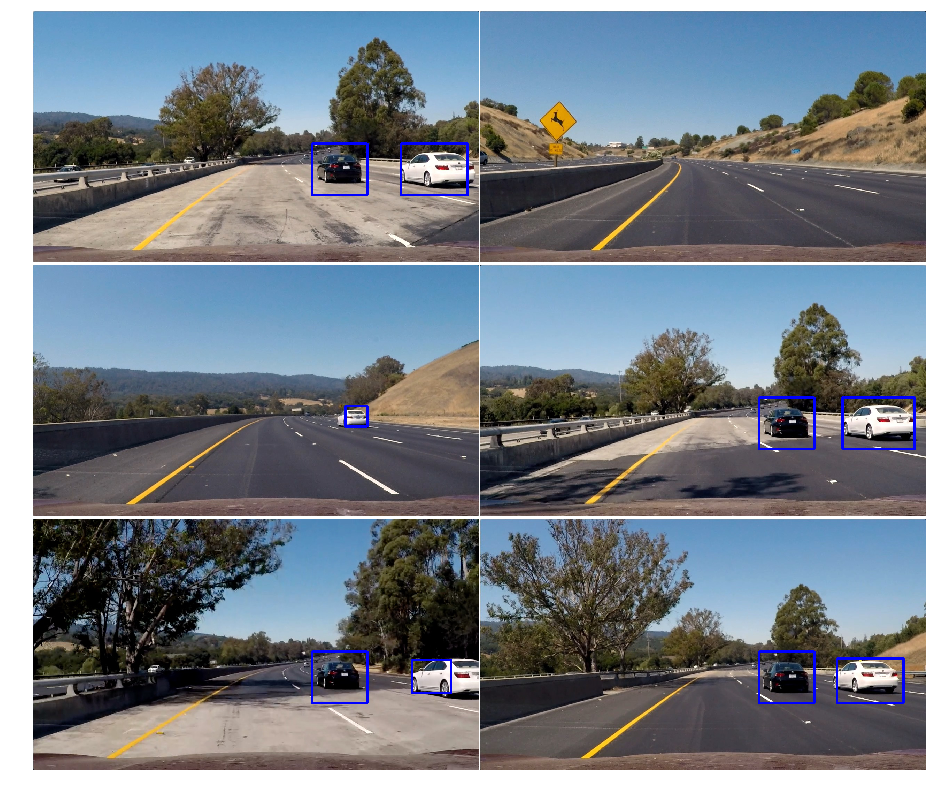

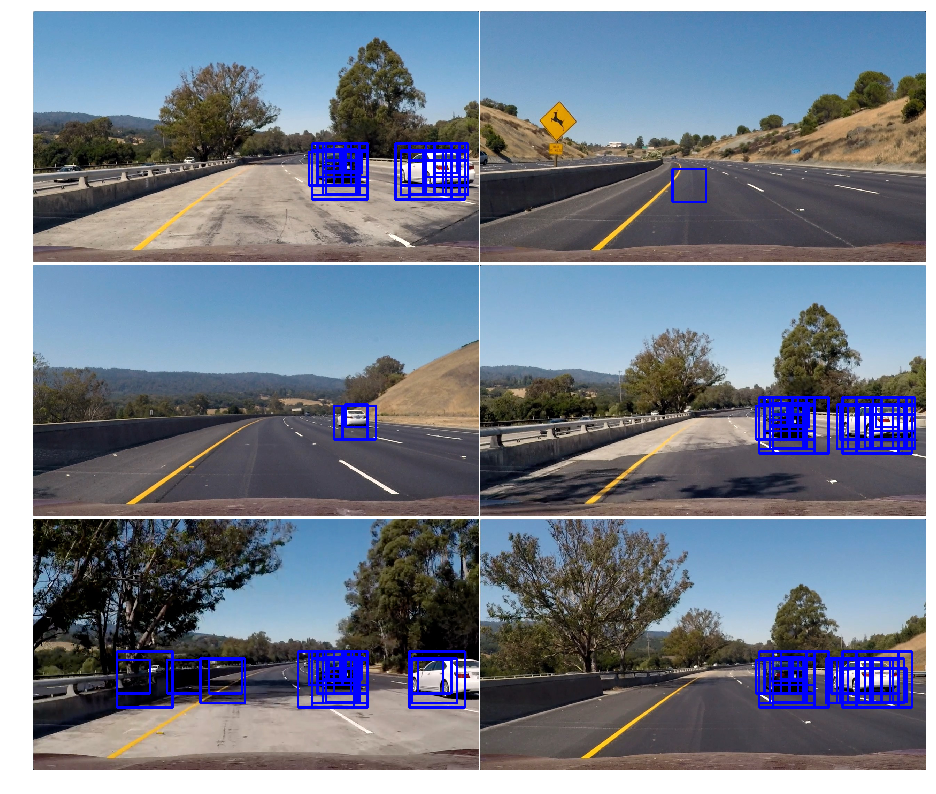

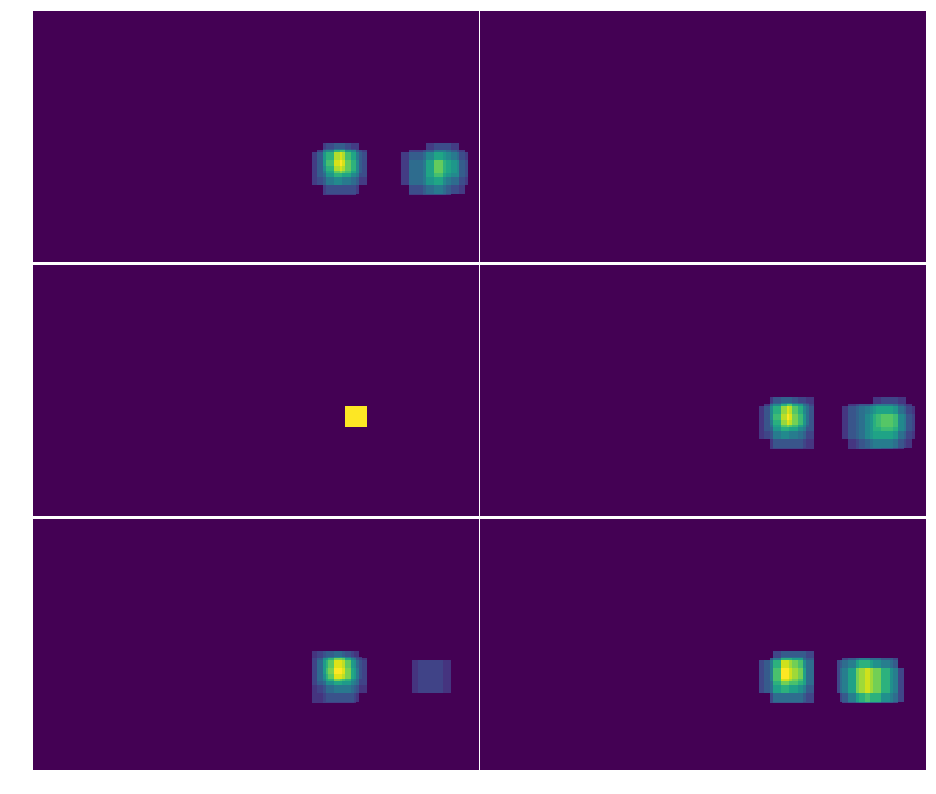

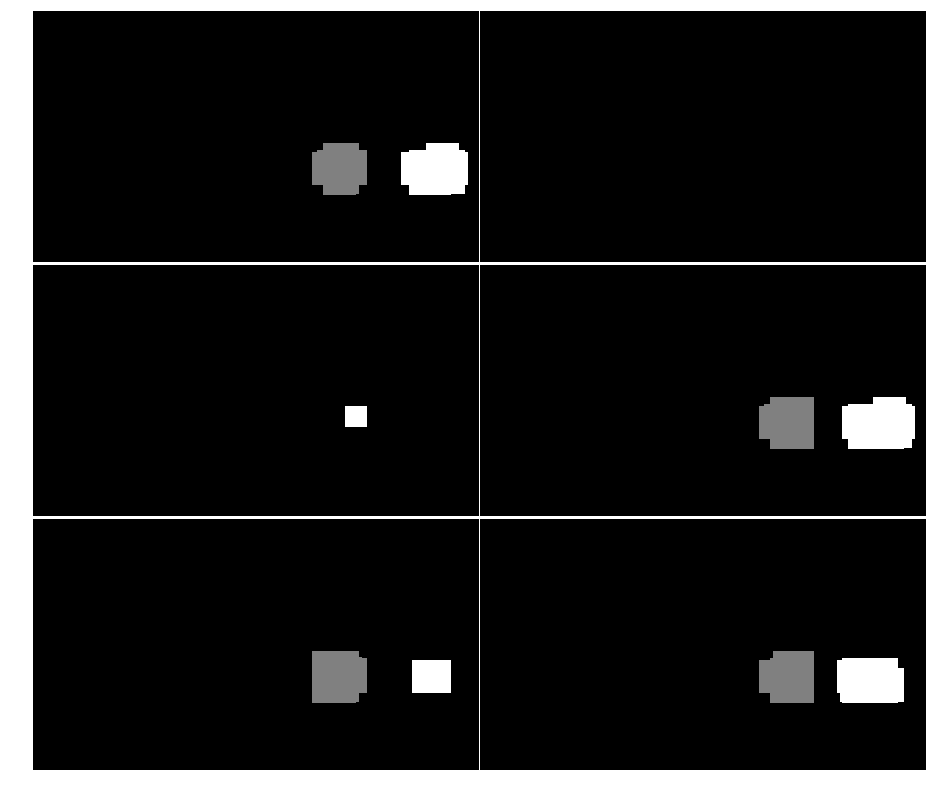

In [9]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
from scipy.ndimage.measurements import label
%matplotlib inline
########################Functions for Testing###########################################

save_path = "./svm_training.p"
svc_pickle = pickle.load( open( save_path, "rb" ) )

colorspace = svc_pickle['colorspace'] 
orient = svc_pickle['orient']
pix_per_cell = svc_pickle['pix_per_cell']
cell_per_block = svc_pickle['cell_per_block']
hog_channel = svc_pickle['hog_channel']
scale = svc_pickle['scale']
histbins = svc_pickle['histbins']
spatialsize = svc_pickle['spatialsize']
svc = svc_pickle['svc']
X_scaler = svc_pickle['scaler']

print("colorspace: ",colorspace)
print("orient: ",orient)
print("pix_per_cell: ",pix_per_cell)
print("cell_per_block: ",cell_per_block)
print("hog_channel: ",hog_channel)
print("scale: ",scale)
print("histbins: ",histbins)
print("spatialsize: ",spatialsize)
print("hog_channel: ",hog_channel)

test_images = glob.glob('./test_images/test*.jpg')

fig, axs = plt.subplots(3, 2, figsize=(16,14))
fig.subplots_adjust(hspace = .004, wspace=.002)
axs = axs.ravel()

fig_w, axs_w = plt.subplots(3, 2, figsize=(16,14))
fig_w.subplots_adjust(hspace = .004, wspace=.002)
axs_w = axs_w.ravel()

fig_h, axs_h = plt.subplots(3, 2, figsize=(16,14))
fig_h.subplots_adjust(hspace = .004, wspace=.002)
axs_h = axs_h.ravel()

fig_l, axs_l = plt.subplots(3, 2, figsize=(16,14))
fig_l.subplots_adjust(hspace = .004, wspace=.002)
axs_l = axs_l.ravel()

for i, im in enumerate(test_images):
    print(i,im)
    draw_img,out_img,heatmap,labels =  process_img(mpimg.imread(im),'IMAGE')
    axs[i].imshow(draw_img)
    axs[i].axis('off')

    axs_w[i].imshow(out_img)
    axs_w[i].axis('off')

    axs_h[i].imshow(heatmap)
    axs_h[i].axis('off')

    axs_l[i].imshow(labels,cmap='gray')
    axs_l[i].axis('off')

    
fig.savefig("./output_images/output_bboxes.png")
fig_w.savefig("./output_images/sliding_windows.jpg")
fig_l.savefig("./output_images/labels_map.png")
fig_h.savefig("./output_images/bboxes_and_heat.png")


In [11]:
save_path = "./svm_training.p"
svc_pickle = pickle.load( open( save_path, "rb" ) )

colorspace = svc_pickle['colorspace'] 
orient = svc_pickle['orient']
pix_per_cell = svc_pickle['pix_per_cell']
cell_per_block = svc_pickle['cell_per_block']
hog_channel = svc_pickle['hog_channel']
scale = svc_pickle['scale']
histbins = svc_pickle['histbins']
spatialsize = svc_pickle['spatialsize']
svc = svc_pickle['svc']
X_scaler = svc_pickle['scaler']

print("colorspace: ",colorspace)
print("orient: ",orient)
print("pix_per_cell: ",pix_per_cell)
print("cell_per_block: ",cell_per_block)
print("hog_channel: ",hog_channel)
print("scale: ",scale)
print("histbins: ",histbins)
print("spatialsize: ",spatialsize)
print("hog_channel: ",hog_channel)

det = CarsDetected(10)

test_out_file = 'test_video_out.mp4'
clip_test = VideoFileClip('test_video.mp4')
clip_test_out = clip_test.fl_image(process_img)
%time clip_test_out.write_videofile(test_out_file, audio=False)

colorspace:  YUV
orient:  9
pix_per_cell:  8
cell_per_block:  2
hog_channel:  ALL
scale:  1.0
histbins:  32
spatialsize:  (32, 32)
hog_channel:  ALL
[MoviePy] >>>> Building video test_video_out.mp4
[MoviePy] Writing video test_video_out.mp4


 97%|█████████▋| 38/39 [00:57<00:01,  1.50s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_video_out.mp4 

CPU times: user 56.6 s, sys: 450 ms, total: 57.1 s
Wall time: 59.9 s


In [12]:

HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(test_out_file))

In [59]:
save_path = "./svm_training.p"
svc_pickle = pickle.load( open( save_path, "rb" ) )

colorspace = svc_pickle['colorspace'] 
orient = svc_pickle['orient']
pix_per_cell = svc_pickle['pix_per_cell']
cell_per_block = svc_pickle['cell_per_block']
hog_channel = svc_pickle['hog_channel']
scale = svc_pickle['scale']
histbins = svc_pickle['histbins']
spatialsize = svc_pickle['spatialsize']
svc = svc_pickle['svc']
X_scaler = svc_pickle['scaler']

print("colorspace: ",colorspace)
print("orient: ",orient)
print("pix_per_cell: ",pix_per_cell)
print("cell_per_block: ",cell_per_block)
print("hog_channel: ",hog_channel)
print("scale: ",scale)
print("histbins: ",histbins)
print("spatialsize: ",spatialsize)
print("hog_channel: ",hog_channel)

det = CarsDetected(10)

project_video_out_file = 'project_video_out.mp4'
clip_project_video = VideoFileClip('project_video.mp4') 
clip_project_video_out = clip_project_video.fl_image(process_img)
%time clip_project_video_out.write_videofile(project_video_out_file, audio=False)

colorspace:  YUV
orient:  9
pix_per_cell:  8
cell_per_block:  2
hog_channel:  ALL
scale:  1.0
histbins:  32
spatialsize:  (32, 32)
hog_channel:  ALL
[MoviePy] >>>> Building video project_video_out.mp4
[MoviePy] Writing video project_video_out.mp4


100%|█████████▉| 1260/1261 [25:42<00:01,  1.22s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_out.mp4 

CPU times: user 29min 9s, sys: 4.37 s, total: 29min 13s
Wall time: 25min 43s


In [60]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(project_video_out_file))